# 5 AutoGen - Enabling LLM-powered agents to cooperate

AutoGen is a framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. AutoGen agents are customizable, conversable, and seamlessly allow human participation. They can operate in various modes that employ combinations of LLMs, human inputs, and tools.

17/06/2024

<img src="https://raw.githubusercontent.com/retkowsky/images/master/autogenlogo.jpg">

> Documentation: https://microsoft.github.io/autogen/

In [1]:
import autogen
import openai
import os
import sys

from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from getpass import getpass
from IPython.display import Markdown, display
from PIL import Image

In [2]:
sys.version

'3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]'

In [3]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    #filter_dict={"tags": ["gpt-4"]},  # comment out to get all
)
# When using a single openai endpoint, you can use the following:
# config_list = [{"model": "gpt-4", "api_key": os.getenv("OPENAI_API_KEY")}]

In [4]:
WORK_DIR = "workdir"

os.makedirs(WORK_DIR, exist_ok=True)

## 1. Agent

In [5]:
config_list = config_list_from_json(env_or_file="OAI_CONFIG_LIST")

In [6]:
assistant = AssistantAgent(
    "assistant",
    llm_config={
        "cache_seed": None,
        "config_list": config_list,
        "temperature": 0,
    },
)

user_proxy = UserProxyAgent("user_proxy",
                            human_input_mode="NEVER",
                            code_execution_config={"work_dir": WORK_DIR})

user_proxy.initiate_chat(
    assistant,
    message=
    "Generate a plot of the APPLE company stocks from the last 30 days and save it \
in the script folder with the 'apple.png' filename")

user_proxy (to assistant):

Generate a plot of the APPLE company stocks from the last 30 days and save it in the script folder with the 'apple.png' filename

--------------------------------------------------------------------------------
assistant (to user_proxy):

To generate a plot of the APPLE company stocks from the last 30 days, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance, which we can then plot using the `matplotlib` library.

Here is the Python code to do this:

```python
# filename: plot_apple_stock.py

import yfinance as yf
import matplotlib.pyplot as plt

# Download the stock data
data = yf.download('AAPL', period='1mo')

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(data.Close)
plt.title('APPLE Stock Price for the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)

# Save the plot
plt.savefig('apple.png')
```

To run this script, you need to have `yfinance` and `matplotlib` in


--------------------------------------------------------------------------------
assistant (to user_proxy):

Great! The script has successfully executed and the required modules have been installed. The plot of the APPLE company stocks from the last 30 days should now be saved in the script folder with the 'apple.png' filename. You can check the script folder to verify the image file.

TERMINATE

--------------------------------------------------------------------------------
user_proxy (to assistant):



--------------------------------------------------------------------------------
assistant (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Generate a plot of the APPLE company stocks from the last 30 days and save it in the script folder with the 'apple.png' filename", 'role': 'assistant'}, {'content': "To generate a plot of the APPLE company stocks from the last 30 days, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance, which we can then plot using the `matplotlib` library.\n\nHere is the Python code to do this:\n\n```python\n# filename: plot_apple_stock.py\n\nimport yfinance as yf\nimport matplotlib.pyplot as plt\n\n# Download the stock data\ndata = yf.download('AAPL', period='1mo')\n\n# Create the plot\nplt.figure(figsize=(14, 7))\nplt.plot(data.Close)\nplt.title('APPLE Stock Price for the Last 30 Days')\nplt.xlabel('Date')\nplt.ylabel('Close Price')\nplt.grid(True)\n\n# Save the plot\nplt.savefig('apple.png')\n```\n\nTo run this script, you need to have `yfinance` and `matplotlib` installed in your Python e

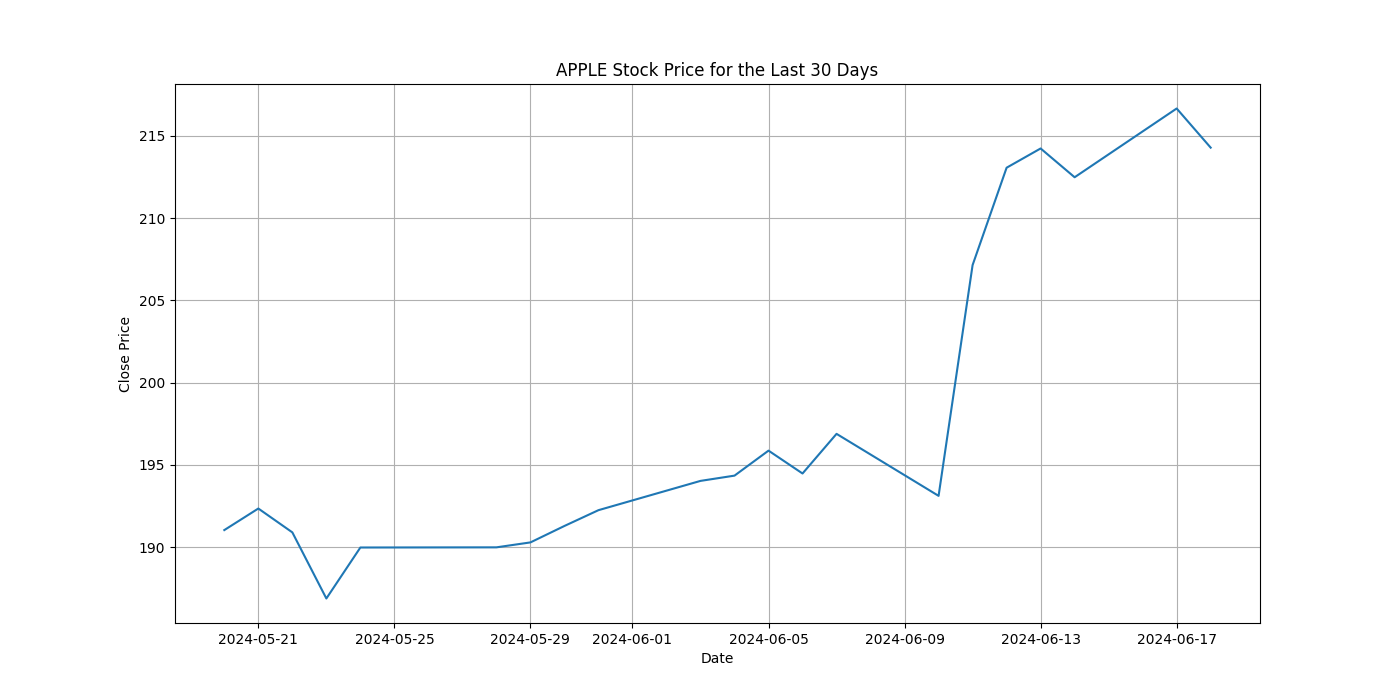

In [7]:
img = Image.open(os.path.join(WORK_DIR, 'apple.png'))
img

In [8]:
!ls $WORK_DIR/apple.png -lt

-rwxrwxrwx 1 root root 43807 Jun 19 08:14 workdir/apple.png


## 2. Multi agents cooperation

In [9]:
llm_config = {
    "cache_seed": None,
    "temperature": 0,
    "config_list": config_list,
}

In [10]:
financial_tasks = [
    """What are the current stock prices of SALESFORCE and GOOGLE, and how is the performance over the past 
    month in terms of percentage change?""",
    """Investigate possible reasons of the stock performance leveraging market news.""",
]

writing_tasks = [
    """Develop an engaging blog post using any information provided."""
]

In [11]:
financial_assistant = autogen.AssistantAgent(
    name="Financial_assistant",
    llm_config=llm_config,
)

research_assistant = autogen.AssistantAgent(
    name="Researcher",
    llm_config=llm_config,
)

writer = autogen.AssistantAgent(
    name="writer",
    llm_config=llm_config,
    system_message="""
        You are a professional writer, known for
        your insightful and engaging articles.
        You transform complex concepts into compelling narratives.
        Reply "TERMINATE" in the end when everything is done.
        """,
)

user_proxy_auto = autogen.UserProxyAgent(
    name="User_Proxy_Auto",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").
    rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": WORK_DIR,
        "use_docker": False,
    },  
)

user_proxy = autogen.UserProxyAgent(
    name="User_Proxy",
    human_input_mode="ALWAYS",  # ask human for input at each step
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").
    rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": WORK_DIR,
        "use_docker": False,
    }, 
)

chat_results = autogen.initiate_chats([
    {
        "sender": user_proxy_auto,
        "recipient": financial_assistant,
        "message": financial_tasks[0],
        "clear_history": True,
        "silent": False,
        "summary_method": "last_msg",
    },
    {
        "sender": user_proxy_auto,
        "recipient": research_assistant,
        "message": financial_tasks[1],
        "max_turns": 2,  
        "summary_method": "reflection_with_llm",
    },
    {
        "sender":
        user_proxy,
        "recipient":
        writer,
        "message":
        writing_tasks[0],
        "carryover":
        "I want to include a figure or a table of data in the blogpost.",  
    },
])


********************************************************************************
Starting a new chat....

********************************************************************************
User_Proxy_Auto (to Financial_assistant):

What are the current stock prices of SALESFORCE and GOOGLE, and how is the performance over the past 
    month in terms of percentage change?

--------------------------------------------------------------------------------
Financial_assistant (to User_Proxy_Auto):

To get the current stock prices and the performance over the past month, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance.

Here is the Python code to get the data:

```python
# Python code
import yfinance as yf
from datetime import datetime, timedelta

# Define the ticker symbols
tickers = ['CRM', 'GOOGL']  # CRM is the ticker for Salesforce, GOOGL for Google

# Get today's date and the date a month ago
today = datetime.today().strftim


--------------------------------------------------------------------------------
Provide feedback to writer. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: exit


In [12]:
for i, chat_res in enumerate(chat_results):
    print("-" * 100)
    print(f"{i+1}th chat:\n")
    print(chat_res.summary)
    print("\n1. Human input in the middle:", chat_res.human_input)
    print("\n2. Conversation cost: ", chat_res.cost)
    print()
    if i == 1:
        assert (
            len(chat_res.chat_history) == 4
        ), f"The chat history should contain at most 4 messages because max_turns is set to 2 in the {i}-th chat."

----------------------------------------------------------------------------------------------------
1th chat:

The current stock price of Salesforce (CRM) is approximately $231.81, and it has decreased by about 19.25% over the past month.

The current stock price of Google (GOOGL) is approximately $175.09, and it has decreased by about 1.03% over the past month.

Please note that these values are approximate and can vary slightly due to market fluctuations.



1. Human input in the middle: []

2. Conversation cost:  {'usage_including_cached_inference': {'total_cost': 0.06636, 'gpt-4': {'cost': 0.06636, 'prompt_tokens': 1404, 'completion_tokens': 404, 'total_tokens': 1808}}, 'usage_excluding_cached_inference': {'total_cost': 0.06636, 'gpt-4': {'cost': 0.06636, 'prompt_tokens': 1404, 'completion_tokens': 404, 'total_tokens': 1808}}}

----------------------------------------------------------------------------------------------------
2th chat:

The assistant provided a Python script to s

## Example 3

In [13]:
def my_writing_task(sender, recipient, context):
    carryover = context.get("carryover", "")
    if isinstance(carryover, list):
        carryover = carryover[-1]

    try:
        filename = context.get("work_dir", "") + "/stock_prices.md"
        with open(filename, "r") as file:
            data = file.read()
    except Exception as e:
        data = f"An error occurred while reading the file: {e}"

    return (
        """Develop an engaging blog post using any information provided. """ +
        "\nContext:\n" + carryover + "\nData:" + data)

In [14]:
research_task = """What are daily stock prices of NVDA and TESLA in the past month. Save the results in a .md file
 named 'stock_prices.md'."""

In [15]:
researcher = autogen.AssistantAgent(
    name="Financial_researcher",
    llm_config=llm_config,
)

writer = autogen.AssistantAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="""
        You are a professional writer, known for
        your insightful and engaging articles.
        You transform complex concepts into compelling narratives.
        Reply "TERMINATE" in the end when everything is done.
        """,
)

user_proxy_auto = autogen.UserProxyAgent(
    name="User_Proxy_Auto",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").
    rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": WORK_DIR,
        "use_docker": False,
    },
)

chat_results = autogen.initiate_chats([
    {
        "sender": user_proxy_auto,
        "recipient": researcher,
        "message": research_task,
        "clear_history": True,
        "silent": False,
        "summary_method": "last_msg",
    },
    {
        "sender": user_proxy_auto,
        "recipient": writer,
        "message": my_writing_task,
        "max_turns": 2,
        "summary_method": "reflection_with_llm",
        "work_dir": WORK_DIR,
    },
])


********************************************************************************
Starting a new chat....

********************************************************************************
User_Proxy_Auto (to Financial_researcher):

What are daily stock prices of NVDA and TESLA in the past month. Save the results in a .md file
 named 'stock_prices.md'.

--------------------------------------------------------------------------------
Financial_researcher (to User_Proxy_Auto):

To get the daily stock prices of NVDA and TESLA in the past month, we can use the `yfinance` library in Python. This library allows us to download stock data from Yahoo Finance.

Here is the Python code to do this:

```python
# filename: get_stock_prices.py

import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

# Define the ticker symbols
tickers = ['NVDA', 'TSLA']

# Define the date range (past month)
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

# Download the


--------------------------------------------------------------------------------
Writer (to User_Proxy_Auto):

# A Month in Review: NVDA and TESLA Stock Prices

In the world of stocks, every day brings a new story. The past month has been no different for two of the tech industry's giants, NVIDIA (NVDA) and Tesla (TSLA). Let's take a closer look at their performance over the past month, from May 20, 2024, to June 18, 2024.

## NVIDIA's Roller Coaster Ride

NVIDIA, a leading player in the GPU market, started the month at a modest $94.78. The stock saw a slight increase the next day, reaching $95.386. However, the following day, it dipped slightly to $94.95. 

The real excitement began on May 23, when the stock price shot up to $103.799. This upward trend continued, with the stock reaching a high of $106.469 on May 24. After a brief dip, the stock price climbed again, reaching a month-high of $135.58 on June 18. 

Throughout the month, NVIDIA's stock price showed a promising upward tren

In [16]:
!ls $WORK_DIR/stock_prices.md -lt

-rwxrwxrwx 1 root root 1559 Jun 19 08:38 workdir/stock_prices.md


In [17]:
with open(os.path.join(WORK_DIR, "stock_prices.md"), 'r') as file:
    markdowncontent = file.read()

display(Markdown(markdowncontent))

## NVDA
| Date                |    NVDA |
|:--------------------|--------:|
| 2024-05-20 00:00:00 |  94.78  |
| 2024-05-21 00:00:00 |  95.386 |
| 2024-05-22 00:00:00 |  94.95  |
| 2024-05-23 00:00:00 | 103.799 |
| 2024-05-24 00:00:00 | 106.469 |
| 2024-05-28 00:00:00 | 113.901 |
| 2024-05-29 00:00:00 | 114.825 |
| 2024-05-30 00:00:00 | 110.5   |
| 2024-05-31 00:00:00 | 109.633 |
| 2024-06-03 00:00:00 | 115     |
| 2024-06-04 00:00:00 | 116.437 |
| 2024-06-05 00:00:00 | 122.44  |
| 2024-06-06 00:00:00 | 120.998 |
| 2024-06-07 00:00:00 | 120.888 |
| 2024-06-10 00:00:00 | 121.79  |
| 2024-06-11 00:00:00 | 120.91  |
| 2024-06-12 00:00:00 | 125.2   |
| 2024-06-13 00:00:00 | 129.61  |
| 2024-06-14 00:00:00 | 131.88  |
| 2024-06-17 00:00:00 | 130.98  |
| 2024-06-18 00:00:00 | 135.58  |

## TSLA
| Date                |   TSLA |
|:--------------------|-------:|
| 2024-05-20 00:00:00 | 174.95 |
| 2024-05-21 00:00:00 | 186.6  |
| 2024-05-22 00:00:00 | 180.11 |
| 2024-05-23 00:00:00 | 173.74 |
| 2024-05-24 00:00:00 | 179.24 |
| 2024-05-28 00:00:00 | 176.75 |
| 2024-05-29 00:00:00 | 176.19 |
| 2024-05-30 00:00:00 | 178.79 |
| 2024-05-31 00:00:00 | 178.08 |
| 2024-06-03 00:00:00 | 176.29 |
| 2024-06-04 00:00:00 | 174.77 |
| 2024-06-05 00:00:00 | 175    |
| 2024-06-06 00:00:00 | 177.94 |
| 2024-06-07 00:00:00 | 177.48 |
| 2024-06-10 00:00:00 | 173.79 |
| 2024-06-11 00:00:00 | 170.66 |
| 2024-06-12 00:00:00 | 177.29 |
| 2024-06-13 00:00:00 | 182.47 |
| 2024-06-14 00:00:00 | 178.01 |
| 2024-06-17 00:00:00 | 187.44 |
| 2024-06-18 00:00:00 | 184.86 |



In [18]:
# Display the plain text version of the Markdown content
plain_text = markdowncontent.replace("**", "").replace("[", "").replace("]", "")
print(plain_text)

## NVDA
| Date                |    NVDA |
|:--------------------|--------:|
| 2024-05-20 00:00:00 |  94.78  |
| 2024-05-21 00:00:00 |  95.386 |
| 2024-05-22 00:00:00 |  94.95  |
| 2024-05-23 00:00:00 | 103.799 |
| 2024-05-24 00:00:00 | 106.469 |
| 2024-05-28 00:00:00 | 113.901 |
| 2024-05-29 00:00:00 | 114.825 |
| 2024-05-30 00:00:00 | 110.5   |
| 2024-05-31 00:00:00 | 109.633 |
| 2024-06-03 00:00:00 | 115     |
| 2024-06-04 00:00:00 | 116.437 |
| 2024-06-05 00:00:00 | 122.44  |
| 2024-06-06 00:00:00 | 120.998 |
| 2024-06-07 00:00:00 | 120.888 |
| 2024-06-10 00:00:00 | 121.79  |
| 2024-06-11 00:00:00 | 120.91  |
| 2024-06-12 00:00:00 | 125.2   |
| 2024-06-13 00:00:00 | 129.61  |
| 2024-06-14 00:00:00 | 131.88  |
| 2024-06-17 00:00:00 | 130.98  |
| 2024-06-18 00:00:00 | 135.58  |

## TSLA
| Date                |   TSLA |
|:--------------------|-------:|
| 2024-05-20 00:00:00 | 174.95 |
| 2024-05-21 00:00:00 | 186.6  |
| 2024-05-22 00:00:00 | 180.11 |
| 2024-05-23 00:00:00 | 173.74 |
| 2